In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 106.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from ultralytics import YOLO
import os
import boto3
import re
import cv2
import matplotlib.pyplot as plt

In [3]:
EPOCHS=int(os.environ.get("epochs", 50))
IMGSZ=640
DATA_CONFIG_PATH = "utils/dataset.yaml"
LOCAL_DATASET_PATH = "dataset/"
LOCAL_LABEL_FOLDER = "/tmp/labels/"

DATASET_PATH = "dataset"

BASE_MODEL_PATH = "models/model.pt"
TRAIN_MODEL_PATH = "models/new-model.pt"
TRAIN_MODEL_PATH_ONNX = "models/new-model.onnx"

AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.environ.get("AWS_S3_BUCKET")
AWS_S3_ENDPOINT = os.environ.get("AWS_S3_ENDPOINT")

In [4]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
client = session.client("s3", endpoint_url=AWS_S3_ENDPOINT)

In [5]:
def download_folder(bucket_name, folder, local_dir=None):
    if local_dir is None:
        local_dir = os.getcwd()

    os.makedirs(local_dir, exist_ok = True)

    paginator = client.get_paginator('list_objects_v2')
    operation_parameters = {'Bucket': bucket_name, 'Prefix': folder}
    page_iterator = paginator.paginate(**operation_parameters)
    for page in page_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                # Determine the local file path
                relative_path = os.path.relpath(key, folder)
                local_file_path = os.path.join(local_dir, relative_path)

                # Create directories if they don't exist
                os.makedirs(os.path.dirname(local_file_path), exist_ok=True)

                # Download the file
                client.download_file(bucket_name, key, local_file_path)
                print(f"Downloaded {key} to {local_file_path}")

In [6]:
def show_image(image_path, label_path):
    image = cv2.imread(image_path)
    with open(label_path, 'r') as handler:
        while True:
            line = handler.readline()
            if not line:
                break
            line = line.split(" ")
            label = int(line[0])
            x, y, w, h = (float(e) for e in line[1:])
            bbox = (float(x), float(y), float(w), float(h))
            img_h, img_w, _ = image.shape
            x1, y1, x2, y2 = x - (w / 2), y - (h / 2), x + (w / 2), y + (h / 2)
            x1, y1, x2, y2 = int(x1 * img_w), int(y1 * img_h), int(x2 * img_w), int(y2 * img_h)
            color = (0,0,255) if label == 1 else (255,0,0)
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color=color, thickness=2)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        handler.close()

In [7]:
download_folder(AWS_S3_BUCKET, DATASET_PATH, LOCAL_DATASET_PATH)

Downloaded dataset/classes.txt to dataset/classes.txt
Downloaded dataset/images/1267fce1-Magic-Hawks-Game-517136550.jpg to dataset/images/1267fce1-Magic-Hawks-Game-517136550.jpg
Downloaded dataset/images/15afa227-sports-basketball-NBA-structure-arena-Slam-Dunk-player-sport-venue-bas_xW7eF6K.jpg to dataset/images/15afa227-sports-basketball-NBA-structure-arena-Slam-Dunk-player-sport-venue-bas_xW7eF6K.jpg
Downloaded dataset/images/16605ae9-kobe-bryants-game-winner-vs-portland-trail-blazers-in-2004_ml78lbvs63_afYnmsP.jpeg to dataset/images/16605ae9-kobe-bryants-game-winner-vs-portland-trail-blazers-in-2004_ml78lbvs63_afYnmsP.jpeg
Downloaded dataset/images/17355bc2-panier-de-basket-exterieur-powerlift-1322675272.jpg to dataset/images/17355bc2-panier-de-basket-exterieur-powerlift-1322675272.jpg
Downloaded dataset/images/2dcd7d1e-BasketballSeasonNeverEndsWithLaunchofEASPORTSNBALIVE...-768915-171522021.jpg to dataset/images/2dcd7d1e-BasketballSeasonNeverEndsWithLaunchofEASPORTSNBALIVE...-76891

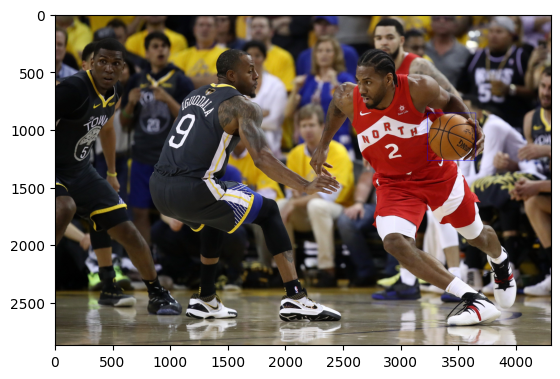

In [8]:
import random
file = random.choice(os.listdir("dataset/images"))
file_name, file_extension = os.path.splitext(file)
label_path = f"dataset/labels/{file_name}.txt"
image_path = f"dataset/images/{file}"
show_image(image_path, label_path)

In [9]:
client.download_file(AWS_S3_BUCKET, BASE_MODEL_PATH, "base-model.pt")

In [10]:
model = YOLO('yolov8n.pt')
results = model.train(data=DATA_CONFIG_PATH, epochs=EPOCHS, imgsz=IMGSZ)

Ultralytics 8.3.145 🚀 Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA RTX A2000 12GB, 12032MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=utils/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrai

train: Scanning /opt/app-root/src/ai-demo/dataset/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3977.6±2054.1 MB/s, size: 463.6 KB)


val: Scanning /opt/app-root/src/ai-demo/dataset/labels.cache... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.91G      1.388      4.349      1.334         33        640: 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all         31         48    0.00129      0.245    0.00126    0.00063

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50      2.29G      1.206      4.134      1.224         43        640: 100%|██████████| 2/2 [00:00<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         31         48    0.00108      0.203    0.00111   0.000631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.29G      1.331       3.99      1.329         42        640: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         31         48    0.00183       0.35     0.0107    0.00592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/50      2.31G      1.126        3.9      1.168         32        640: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         31         48    0.00204      0.392     0.0545     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.32G      1.254      3.812      1.149         44        640: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         31         48     0.0026      0.496      0.155      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/50      2.32G      1.118      3.301      1.075         39        640: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         31         48    0.00285      0.537      0.164      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.32G      1.281      3.019       1.08         48        640: 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         31         48    0.00259      0.474       0.14     0.0971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50      2.34G      1.251      2.576      1.152         35        640: 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         31         48     0.0027      0.494      0.153     0.0894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.34G      1.092      2.387      1.049         36        640: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         31         48    0.00319      0.601      0.187      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.35G      1.208      2.436      1.063         44        640: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         31         48    0.00357      0.688      0.228      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50      2.36G      1.227      2.132      1.067         54        640: 100%|██████████| 2/2 [00:00<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         31         48    0.00368      0.708      0.272      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50      2.37G      1.101       2.02      1.023         61        640: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         31         48    0.00368      0.708      0.323      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.37G      1.035       2.02     0.9848         43        640: 100%|██████████| 2/2 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         31         48    0.00381      0.726      0.321       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.37G     0.9944      1.994      0.997         43        640: 100%|██████████| 2/2 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         31         48    0.00361      0.683      0.317      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.38G      1.038      1.949     0.9806         43        640: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         31         48    0.00339      0.641      0.304       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.38G     0.9869       1.93       1.03         42        640: 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         31         48    0.00348      0.663       0.32      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      17/50      2.38G      1.067      1.946      1.028         34        640: 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         31         48    0.00347      0.664      0.323      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/50      2.38G     0.9919      1.814      1.053         49        640: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         31         48    0.00356      0.686      0.319      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       2.4G      1.029      1.974      1.038         32        640: 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         31         48    0.00386      0.748      0.296      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       2.4G     0.8772      1.569     0.9255         42        640: 100%|██████████| 2/2 [00:00<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         31         48    0.00456      0.793      0.312      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       2.4G      1.015      1.822      1.042         32        640: 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         31         48    0.00463      0.895      0.359      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       2.4G      1.068      1.746      1.045         44        640: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.67it/s]

                   all         31         48    0.00465      0.895      0.378      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       2.4G     0.8847      1.553     0.9669         43        640: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         31         48    0.00474      0.915      0.331      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       2.4G     0.8713       1.44     0.9304         49        640: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         31         48    0.00483      0.935      0.343      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       2.4G     0.9346      1.712     0.9554         45        640: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         31         48    0.00473      0.915      0.396      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       2.4G     0.8943      1.491     0.9178         43        640: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         31         48    0.00473      0.915      0.382      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       2.4G     0.8589       1.37     0.9517         43        640: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         31         48      0.936      0.173      0.396      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.4G     0.9264      1.613     0.9944         39        640: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         31         48      0.936      0.173      0.396      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.4G     0.8125      1.386     0.9017         51        640: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         31         48      0.907     0.0889      0.379      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       2.4G     0.9157      1.512     0.9805         40        640: 100%|██████████| 2/2 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         31         48      0.959       0.08      0.492      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       2.4G     0.8376      1.368      0.953         51        640: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         31         48      0.959       0.08      0.492      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       2.4G     0.8265      1.378     0.9418         50        640: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         31         48      0.971       0.11      0.721       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       2.4G     0.8717       1.55      1.009         44        640: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         31         48          1      0.144      0.805      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       2.4G     0.7718      1.382     0.9084         41        640: 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         31         48          1      0.144      0.805      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       2.4G     0.7143      1.251     0.9269         46        640: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         31         48      0.857      0.187      0.821      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.4G     0.9269      1.513       1.06         30        640: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         31         48      0.934      0.329      0.793      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50       2.4G      0.752      1.196     0.9099         37        640: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         31         48      0.934      0.329      0.793      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       2.4G     0.7517      1.308      0.916         42        640: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.54it/s]

                   all         31         48      0.908      0.444      0.783      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.4G     0.7805      1.201     0.9417         53        640: 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.64it/s]

                   all         31         48      0.919      0.546      0.804       0.69

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50       2.4G     0.7271      1.265     0.9388         48        640: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.56it/s]

                   all         31         48      0.919      0.546      0.804       0.69


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.41G      0.681      1.519     0.8765         23        640: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         31         48      0.929      0.607      0.839      0.716

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      42/50      2.42G     0.6803       1.42     0.8516         23        640: 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         31         48      0.931      0.637      0.869      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.42G     0.7674      1.662     0.9283         23        640: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         31         48      0.931      0.637      0.869      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.42G     0.6496      1.395     0.8432         23        640: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         31         48      0.927      0.763      0.879      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.42G     0.6992      1.478     0.8893         22        640: 100%|██████████| 2/2 [00:00<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]

                   all         31         48      0.927      0.763      0.879      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.42G     0.7075      1.463      0.879         25        640: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         31         48       0.93      0.802      0.893      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.42G     0.5868      1.425     0.8359         24        640: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.55it/s]

                   all         31         48       0.93      0.802      0.893      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.42G     0.6194      1.457      0.859         20        640: 100%|██████████| 2/2 [00:00<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31         48      0.959      0.838        0.9      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.42G     0.7124      1.508     0.8921         27        640: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         31         48      0.959      0.838        0.9      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.42G     0.6508      1.452     0.8538         25        640: 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         31         48      0.939      0.877      0.911      0.765



50 epochs completed in 0.009 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA RTX A2000 12GB, 12032MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


                   all         31         48       0.94      0.877       0.91      0.765
                  Ball         21         23      0.901      0.794      0.844      0.728
                  Hoop         25         25      0.978       0.96      0.976      0.802
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train3


In [12]:
model = YOLO('runs/detect/train3/weights/best.pt')

In [13]:
model.export(format="onnx")

Ultralytics 8.3.145 🚀 Python-3.11.9 torch-2.6.0+cu126 CPU (Intel Core(TM) i7-14700F)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train3/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.53', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 MB 103.7 MB/s eta 0:00:0000:0100:01

requirements: AutoUpdate success ✅ 7.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 8.2s, saved as 'runs/detect/train3/weights/best.onnx' (11.7 MB)

Export complete (9.0s)
Results saved to /opt/app-root/src/ai-demo/runs/detect/train3/weights
Predict:         yolo predict task=detect model=runs/detect/train3/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train3/weights/best.onnx imgsz=640 data=utils/dataset.yaml  
Visualize:       https://netron.app


'runs/detect/train3/weights/best.onnx'

In [14]:
model_path = "runs/detect/train3/weights/best.onnx"

In [16]:
client.upload_file(model_path, AWS_S3_BUCKET, TRAIN_MODEL_PATH_ONNX)

In [17]:
client.upload_file('runs/detect/train3/weights/best.pt', AWS_S3_BUCKET, TRAIN_MODEL_PATH)

In [18]:
client.upload_file('runs/detect/train3/results.csv', AWS_S3_BUCKET, 'results.csv')